<a href="https://colab.research.google.com/github/apothula/dl/blob/main/Seg/02_FCN32s_Road_CE_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Semantic Segmentation using Fully Convolutional Layers (FCN)</h1>

The first approach to performing **Semantic Segmentation** using a deep neural network was proposed in the 2015 CVPR paper <a href="https://arxiv.org/pdf/1411.4038.pdf" target="_blank">Fully Convolutional Networks for Semantic Segmentation</a> by Jonathan Long, Evan Shelhamer, and Trevor Darrell. In this notebook, we will demonstrate how to implement the Fully Connected Network (FCN) for semantic segmentation from scratch.

Since that time, several other architectures have been developed for semantic segmentation, such as UNet and DeepLabV3+. However, the simplicity of the FCN architecture is an ideal place to start for introducing the topic and the general approach used to achieve semantic segmentation.

Semantic segmentation is closely related to image classification, with the main difference being that every pixel in the image is classified as opposed to a single label assigned to the entire image. **In semantic segmentation, the training data "labels" are represented as segmentation masks where every pixel in the mask is assigned to a unique class.**

There are several metrics and loss functions that can be used for semantic segmentation, but in this notebook, we will use pixel accuracy as the metric and cross-entropy as the loss function.

<img src='https://opencv.org/wp-content/uploads/2022/07/c4-05-fcn-feature-image.png' align='center' width='1000'>

## Table of Contents

* [1 System Configuration](#1-System-Configuration)
* [2 Training and Dataset Configurations](#2-Training-and-Dataset-Configurations)
* [3 Fully Convolutional Networks](#3-Fully-Convolutional-Networks)
* [4 Dataset Preparation](#4-Dataset-Preparation)
* [5 Custom Data Loader Class](#5-Custom-Data-Loader-Class)
* [6 Helper Functions and Utilities](#6-Helper-Functions-and-Utilities)
* [7 Using the Custom Data Loader Class](#7-Using-the-Custom-Data-Loader-Class)
* [8 Compile and Train the Model](#8-Compile-and-Train-the-Model)
* [9 Plot the Training Results](#9-Plot-the-Training-Results)
* [10 Perform Inference](#10-Perform-Inference)
* [11 Conclusion](#11-Conclusion)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob as glob
import albumentations as A
import requests
import zipfile

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, Activation, Input,
                                     MaxPool2D, Conv2DTranspose)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False
plt.rcParams['image.cmap'] = 'gray'

## 1 System Configuration

In [2]:
def system_config(SEED_VALUE):

    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config(7)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


## 2 Training and Dataset Configurations

In [3]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 2
    IMG_WIDTH:   int = 224
    IMG_HEIGHT:  int = 224
    DATA_TRAIN_IMAGES: str = 'dataset_kitti_road_segmentation/train/images/*.png'
    DATA_TRAIN_LABELS: str = 'dataset_kitti_road_segmentation/train/masks/*.png'
    DATA_VALID_IMAGES: str = 'dataset_kitti_road_segmentation/valid/images/*.png'
    DATA_VALID_LABELS: str = 'dataset_kitti_road_segmentation/valid/masks/*.png'

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 8
    EPOCHS:          int = 51
    LEARNING_RATE: float = 0.0001
    CHECKPOINT_DIR:  str = 'model_checkpoint/FCN_Road'

@dataclass(frozen=True)
class InferenceConfig:
    NUM_BATCHES:     int = 3

## 3 Fully Convolutional Networks

* Fully Convolutional Networks, or FCNs, are a type of neural network that is mainly utilized for semantic segmentation. Convolution, pooling, and upsampling are the only layers used. Because wide layers aren't used, there are fewer parameters (making the networks faster to train). **This also means that an FCN can handle a wide range of image sizes since there is no longer a size constraint imposed by the fully connected layers.**
<br><br>
* The FCN network has a downsampling path (also known as an **encoder**) for extracting and interpreting the context (image to feature maps), as well as an upsampling path (**decoder**) that uses **1x1 convolution** to limit the depth of the output map to the number of classes, and **transposed convolution** for upsampling and localization. An important feature of transposed convolutions is that the filter parameters are **learned**.


<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-fcn-architecture.png" width=1000>

* FCNs also use **1x1 convolutions** prior to upsampling, which maintains the same spatial size of the feature maps while reducing the number of channels in the network to produce a final segmentation map with a depth that is equal to the number of classes. This is sometimes referred to as "channel pooling" since it is often used to reduce the number of channels in the network.
<br><br>
* The figure below depicts the three main components used in FCNs, which begins with a **CNN** to extract features, followed by a **1x1 convolution** layer which transforms the number of channels in the network to the number of classes, and then finally **transposed convolution**, which upsamples the spatial size of the feature maps to back to the original size of the input image.

<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-fcn-architecture-blocks.png" width=1000>

### 3.1 Versions of FCN

There are three versions of FCN described in the original research paper related to the upsampling portion of the network (also referred to as the "decoder"). They are:

* FCN-32s: Upsample the feature map from the final convolutional layer directly by using a single transposed convolution layer with a stride of 32.
* FCN-16s: Combines predictions from both the final layer and the fourth Max Pooling layer (pool4) layer, at stride 16. This helps the network predict finer details while retaining high-level semantic information.
* FCN-8s: Combines predictions from both the third and fourth Max Pooling layers at stride 8. This gives the best results.

The following figure summarizes the upsampling approach for all three algorithms. The use of data from prior layers in the network in FCN-16s and FCN-8s is referred to as "skip layer fusion" in the original research paper. Connections like these are also often referred to as skip connections.

<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-fcn-32s-16s-8s.png">

To keep things simple, we will implement the FCN-32s architecture, which uses a VGG-16 backbone. However, it is worth noting that the authors in the original <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf" target="_blank">FCN paper</a> also experimented with other backbones, namely, AlexNet and GoogLeNet, and it is possible to use other backbones for the feature extraction portion of the network.

### 3.2 Modeling FCN-32s with VGG-16 Backbone
In the implementation below, we model FCN-32s with a VGG-16 backbone. In the original FCN-32s architecture, the authors replaced the two fully-connected layers of VGG-16 with two convolutional layers that transitioned from a 7x7 convolution to a 1x1 convolution (both with 4096 filters). Dropout layers were also added at each stage. These modified layers were then followed with a single 1x1 convolution with the number of filters was set to the number of classes. This was then followed by a transposed convolution with a stride of 32 to achieve the final segmentation map. To keep things simple and reduce the number of parameters in the model (thus, reducing the training time), we simply replaced the fully-connected layers in VGG-16 with a single 1x1 convolution with the number of filters set to the number of classes, followed by a transposed convolution with a stride of 32.

In [4]:
def fcn32s_vgg16(num_classes, shape):

    model_input = Input(shape=shape)

    # Conv block 1.
    x = Conv2D(64, (3, 3), padding='same')(model_input)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 2.
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 3.
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 4.
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 5.
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # 1x1 convolution to limit the depth of the feature maps to the number of classes.
    x = Conv2D(num_classes, (1, 1), padding='same')(x)

    # Upsampling using Transposed Convolution.
    outputs = Conv2DTranspose(num_classes, kernel_size=(64, 64), strides=(32, 32),  padding='same')(x)

    model_output = Activation('softmax')(outputs)

    model = Model(inputs=model_input, outputs=model_output)

    return model

In [5]:
model = fcn32s_vgg16(num_classes=DatasetConfig.NUM_CLASSES,
                     shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                             

* Earlier in the course, we covered image classification, in which the last output layer produces a probability that the image belongs to a particular class.
* Semantic segmentation is similar to image classification, but every pixel in the image is assigned to a single class.
* In image classification, the output has the shape of `[B, C]`, where `B` is the batch size, and `C` is the number of classes.
* In semantic segmentation, the output has two additional dimensions, with a shape of `[B, H, W, C]`, where `H` and `W`, are the spatial dimensions of the image.

## 4 Dataset Preparation

### 4.1 Download and Extract the Dataset

This notebook will use the road segmentation images from the <a href="http://www.cvlibs.net/datasets/kitti/eval_road.php" target="_blank"> KITTI Road Evaluation dataset</a>. Although you can find the original dataset from the above link, we are providing a smaller version of the dataset to work with. The dataset that we will download further below has the following structure.

```
dataset_kitti_road_segmentation/

    ├── train
    │   ├── images [247 samples]
    │   └── masks  [247 samples]
    └── valid
        ├── images [42 samples]
        └── masks  [42 samples]
```

In [6]:
# To Download processed dataset.
def download_file(url, save_name):
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)

In [7]:
# To Unzip the dataset file.
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [8]:
save_name = "dataset_kitti_road_segmentation.zip"

if not os.path.exists(save_name):
    download_file(
        "https://www.dropbox.com/s/6vpsgn4gqtdiu01/dataset_kitti_road_segmentation.zip?dl=1",
        save_name
    )

    unzip(zip_file=save_name)


Extracted all


### 4.2 Mask Pre-Processing

There are a few important things to mention regarding the dataset:
* The ground truth segmentation masks have three colors  (red, pink, and black). Red represents the background, pink represents the main road we wish to segment from the background, and black represents secondary roads/walkways other than the main road. We are only interested in the pink segmentation region as that consists of the main road in the original image.
* We, therefore, need to pre-process the segmentation masks in the dataset to create a binary mask consisting of just the main road and the background.
* The following sequence summarizes the processing steps that we will implement further below in the notebook. The main thing to note is that we create a single channel mask whose pixel values represent the class IDs.
* When we display the segmentation results, we can use a color map (dictionary) to map class IDs to colors. Since the original color map is harder to visualize, we decided to use a different color assignment for the two classes for visualization purposes (green for the main road and black for the background).
<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-mask-preprocessing.png" align='center' width=700>

## 5 Custom Data Loader Class

The next code block defines the `CustomSegDataLoader` class that we developed in the introductory notebook in this module. The only differnece is that this version uses a simplified verion of the `transforms()` method which only includes horizontal flipping.

In [9]:
# Custom Class for creating training and validation (segmentation) dataset objects.
class CustomSegDataLoader(Sequence):

    def __init__(self, batch_size, image_size, image_paths, mask_paths, num_classes, aug):

        self.batch_size  = batch_size
        self.image_size  = image_size
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.num_classes = num_classes
        self.aug = aug

        self.x = np.empty((self.batch_size,) + self.image_size + (3,), dtype="float32")
        self.y = np.empty((self.batch_size,) + self.image_size, dtype="float32")

        if self.aug:
            self.train_transforms = self.transforms()

        self.resize_transforms = self.resize()

    def __len__(self):

        return len(self.mask_paths) // self.batch_size

    def transforms(self):

        # Data augmentation.
        train_transforms = A.Compose([A.HorizontalFlip(p=0.33),])
        return train_transforms

    def resize(self):

        resize_transforms = A.Resize(
            height=self.image_size[0], width=self.image_size[1],
            interpolation=cv2.INTER_NEAREST,
            always_apply=True, p=1
        )
        return resize_transforms

    def reset_array(self):
        self.x.fill(0.)
        self.y.fill(0.)

    def __getitem__(self, idx):
        self.reset_array()
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i : i + self.batch_size]
        batch_mask_paths = self.mask_paths[i : i + self.batch_size]

        for j, (input_image, input_mask) in enumerate(zip(batch_image_paths, batch_mask_paths)):

            # Read the image and convert to RGB.
            img = cv2.imread(input_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Read the mask and convert to RGB.
            msk = cv2.imread(input_mask)
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)

            # Resize the image and mask.
            resized  = self.resize_transforms(image=img, mask=msk)
            img, msk = resized['image'], resized['mask']

            if self.aug:
                # Apply augmentations.
                train_augment = self.train_transforms(image=img, mask=msk)
                img, msk = train_augment['image'], train_augment['mask']

            # Store image in x.
            self.x[j] = img / 255. # Normalizing image to be in range [0.0, 1.0]

            # Convert RGB segmentation mask to multi-channel (one-hot) encoded arrays where
            # each channel represents a single class whose pixel values are either 0 or 1,
            # where a 1 represents a pixel location associated with the class that corresponds
            # to the channel.
            msk = rgb_to_onehot(msk)

            # Convert the multi-channel (one-hot encoded) mask to a single channel (grayscale)
            # representation whose values contain the class IDs for each class (essentially
            # collapsing the one-hot encoded arrays into a single channel).
            self.y[j] = msk.argmax(-1)

        return self.x, self.y

## 6 Helper Functions and Utilities


The color mapping dictionaries below define the maping between class IDs and RGB colors. The first dictionary defines the color mapping in the original dataset. It is used to map the RGB ground truth masks into a single channel representation that encodes the class IDs. The second color mapping is used to map class IDs to RGB values to render the predicted segmentation maps overlayed on the original image. The alternate color mapping is not required but was selected for visualization purposes only.

In [10]:
id2color = {
    0: (255, 0, 0),   # Background: red
    1: (255, 0, 255), # Road: pink
}

id2color_display = {
    0: (0, 0, 0),     # Background: black
    1: (0, 255, 0),   # Road: green
}

When preparing the masks in the custom data loader class, we need to convert the RGB images to one-hot encoded images where the number of channels will be the same as the number of channels (classes) in the dataset. The following function performs this conversion.

In [11]:
# Function to one-hot encode RGB mask labels.
def rgb_to_onehot(rgb_arr, color_map=id2color, num_classes=DatasetConfig.NUM_CLASSES):

    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros( shape, dtype=np.float32 )

    for i, classes in enumerate(color_map):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_map[i], axis=1).reshape(shape[:2])

    return arr

We will also need to make use of the function below that will convert a single channel mask to an RGB representation for visualization purposes. Each class ID in the single-channel mask will be converted to a different color according to the `id2color` dictionary mapping.

In [12]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):

    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[single_layer==k] = color_map[k]

    return np.float32(output) / 255. # return a floating point array in range [0.0, 1.0]

Helper function to overlay an RGB segmentation map on top of an RGB image.

In [13]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return np.clip(image, 0.0, 1.0)

The convenience function below will display the original image, the ground truth mask, and the ground truth mask overlayed on the original image. Note that there is an optional argument that allows you to control if the ground truth mask is displayed as a grayscale image or a color image.

In [14]:
def display_image_and_mask(data_list, color_mask=False, color_map=id2color):

    plt.figure(figsize=(16, 6))
    title = ['GT Image', 'GT Mask', 'Overlayed Mask']

    grayscale_gt_mask = data_list[1]

    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)

    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], rgb_gt_mask)

    data_list.append(overlayed_image)

    for i in range(len(data_list)):
        plt.subplot(1, len(data_list), i+1)
        plt.title(title[i])
        if title[i] == 'GT Mask':
            if color_mask:
                plt.imshow(np.array(rgb_gt_mask))
            else:
                plt.imshow(np.array(grayscale_gt_mask))
        else:
            plt.imshow(np.array(data_list[i]))
        plt.axis('off')

    plt.show()

## 7 Using the Custom Data Loader Class

Here we define the `create_datasets()` function used below to generate training and validation dataset objects for the KITTI Road dataset. Notice that the augmentation flag for the validation dataset is explicitly set to `False` since data augmentation should only be an option for the training dataset.

In [15]:
def create_datasets(aug=False):

    # Training image and mask paths.
    train_images = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_IMAGES}"))
    train_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_LABELS}"))

    # Validation image and mask paths.
    valid_images = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_IMAGES}"))
    valid_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_LABELS}"))

    # Train data loader.
    train_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=train_images,
                                   mask_paths=train_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=aug,
                                  )
    # Validation data loader.
    valid_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=valid_images,
                                   mask_paths=valid_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=False,
                                  )

    return train_ds, valid_ds

Now we call the above function to create the dataset objects and notice that the augmentation flag is set to `True`, but is only applied to the training dataset in the function above.

In [16]:
train_ds, valid_ds = create_datasets(aug=True)

### 7.1 Display Sample Training Images

In the code cell below, we loop over the first three images in the training dataset and display the original image, the associated ground truth mask, and the ground truth mask overlayed on the original image. The overlay helps us better visualize the segmented classes in the context of the original image.

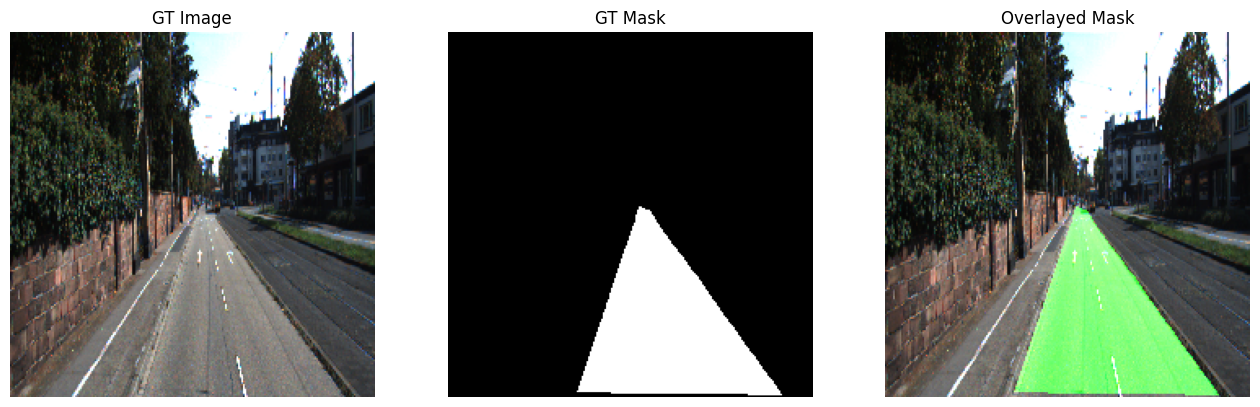

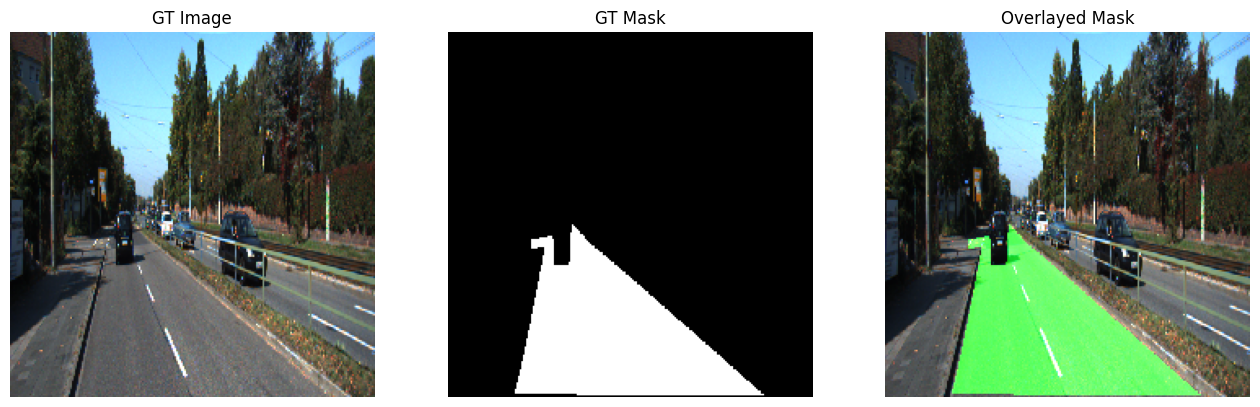

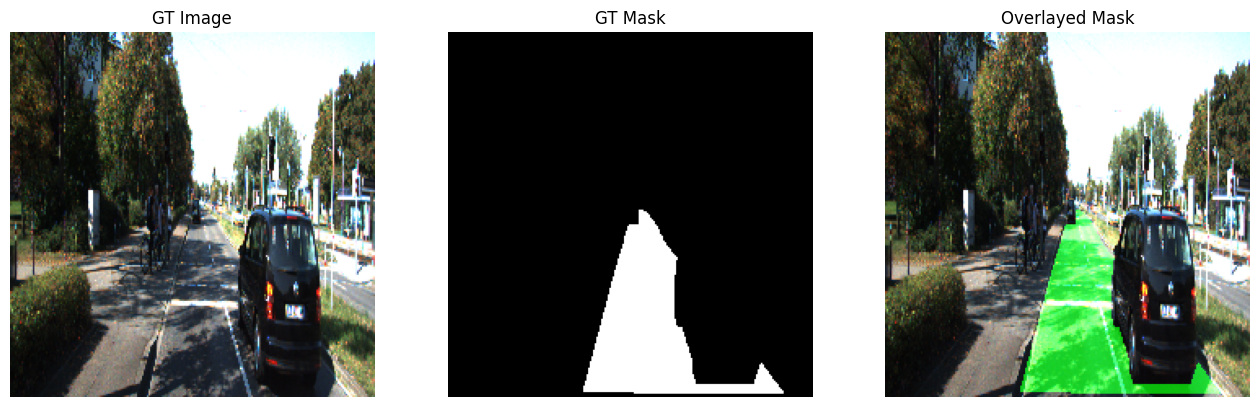

In [17]:
for i, (images, masks) in enumerate(train_ds):
    if i == 3:
        break
    image, mask = images[0], masks[0]
    display_image_and_mask([image, mask], color_mask=False, color_map=id2color_display)

## 8 Compile and Train the Model

### 8.1 Compile the Model

In [18]:
model.compile(optimizer=Adam(learning_rate=TrainingConfig.LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
             )

### 8.2 Adding Model Checkpoint Callback

In the next code cell, we accomplish two important things. First, we create a new directory for the current training model checkpoint to be saved. This will ensure that the previous training checkpoints are not overwritten. We also create a `ModelCheckpoint` callback to save the best model according to the smallest validation loss. This will ensure that we don't need to manually monitor the training for the "best" model.

In [19]:
# Create a new checkpoint directory every time.
if not os.path.exists(TrainingConfig.CHECKPOINT_DIR):
    os.makedirs(TrainingConfig.CHECKPOINT_DIR)

num_versions = len(os.listdir(TrainingConfig.CHECKPOINT_DIR)) + 1
version_dir = TrainingConfig.CHECKPOINT_DIR +'/version_roadseg_' + str(num_versions)
os.makedirs(version_dir)

# Callback to save the best model based on validation loss.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=version_dir,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='auto',
                                                               save_best_only=True,
                                                              )

### 8.3 Train the Model

In [20]:
history = model.fit(train_ds,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_data=valid_ds,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[model_checkpoint_callback],
                   )

Epoch 1/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


29/30 [============================>.] - ETA: 0s - loss: 0.6730 - accuracy: 0.6759

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 26s 625ms/step - loss: 0.6724 - accuracy: 0.6756 - val_loss: 0.6143 - val_accuracy: 0.6789
Epoch 2/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 19s 606ms/step - loss: 0.4816 - accuracy: 0.7644 - val_loss: 0.3332 - val_accuracy: 0.8350
Epoch 3/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


28/30 [===========================>..] - ETA: 0s - loss: 0.2797 - accuracy: 0.8732

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 24s 785ms/step - loss: 0.2790 - accuracy: 0.8732 - val_loss: 0.2848 - val_accuracy: 0.8652
Epoch 4/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


28/30 [===========================>..] - ETA: 0s - loss: 0.2143 - accuracy: 0.9085

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 17s 541ms/step - loss: 0.2138 - accuracy: 0.9084 - val_loss: 0.1752 - val_accuracy: 0.9238
Epoch 5/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 19s 605ms/step - loss: 0.1797 - accuracy: 0.9235 - val_loss: 0.1618 - val_accuracy: 0.9288
Epoch 6/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 18s 580ms/step - loss: 0.1694 - accuracy: 0.9276 - val_loss: 0.1599 - val_accuracy: 0.9319
Epoch 7/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


27/30 [==========================>...] - ETA: 0s - loss: 0.1664 - accuracy: 0.9273

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 17s 528ms/step - loss: 0.1663 - accuracy: 0.9295 - val_loss: 0.1702 - val_accuracy: 0.9347
Epoch 8/51
30/30 [==============================] - 17s 537ms/step - loss: 0.1599 - accuracy: 0.9330 - val_loss: 0.2044 - val_accuracy: 0.9084
Epoch 9/51
30/30 [==============================] - 16s 524ms/step - loss: 0.1634 - accuracy: 0.9317 - val_loss: 0.1607 - val_accuracy: 0.9275
Epoch 10/51
30/30 [==============================] - 18s 595ms/step - loss: 0.1478 - accuracy: 0.9384 - val_loss: 0.1287 - val_accuracy: 0.9424
Epoch 11/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


28/30 [===========================>..] - ETA: 0s - loss: 0.1380 - accuracy: 0.9403

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 17s 550ms/step - loss: 0.1370 - accuracy: 0.9405 - val_loss: 0.1289 - val_accuracy: 0.9417
Epoch 12/51
30/30 [==============================] - 19s 628ms/step - loss: 0.1324 - accuracy: 0.9428 - val_loss: 0.1261 - val_accuracy: 0.9435
Epoch 13/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


28/30 [===========================>..] - ETA: 0s - loss: 0.1253 - accuracy: 0.9455

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 18s 572ms/step - loss: 0.1244 - accuracy: 0.9457 - val_loss: 0.1188 - val_accuracy: 0.9471
Epoch 14/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 18s 589ms/step - loss: 0.1257 - accuracy: 0.9459 - val_loss: 0.1132 - val_accuracy: 0.9499
Epoch 15/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


27/30 [==========================>...] - ETA: 0s - loss: 0.1237 - accuracy: 0.9457

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 17s 545ms/step - loss: 0.1208 - accuracy: 0.9473 - val_loss: 0.1140 - val_accuracy: 0.9492
Epoch 16/51
30/30 [==============================] - 20s 643ms/step - loss: 0.1163 - accuracy: 0.9484 - val_loss: 0.1065 - val_accuracy: 0.9525
Epoch 17/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


28/30 [===========================>..] - ETA: 0s - loss: 0.1157 - accuracy: 0.9484

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 14s 439ms/step - loss: 0.1166 - accuracy: 0.9480 - val_loss: 0.1156 - val_accuracy: 0.9505
Epoch 18/51
30/30 [==============================] - 15s 474ms/step - loss: 0.1237 - accuracy: 0.9470 - val_loss: 0.1163 - val_accuracy: 0.9494
Epoch 19/51
30/30 [==============================] - 14s 442ms/step - loss: 0.1100 - accuracy: 0.9516 - val_loss: 0.1065 - val_accuracy: 0.9554
Epoch 20/51
30/30 [==============================] - 14s 455ms/step - loss: 0.1073 - accuracy: 0.9544 - val_loss: 0.1205 - val_accuracy: 0.9513
Epoch 21/51
30/30 [==============================] - 14s 463ms/step - loss: 0.1051 - accuracy: 0.9551 - val_loss: 0.1094 - val_accuracy: 0.9530
Epoch 22/51
30/30 [==============================] - 19s 624ms/step - loss: 0.1001 - accuracy: 0.9574 - val_loss: 0.1007 - val_accuracy: 0.9575
Epoch 23/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 17s 555ms/step - loss: 0.0968 - accuracy: 0.9594 - val_loss: 0.0858 - val_accuracy: 0.9652
Epoch 24/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 16s 496ms/step - loss: 0.0866 - accuracy: 0.9638 - val_loss: 0.0893 - val_accuracy: 0.9641
Epoch 25/51
30/30 [==============================] - 15s 497ms/step - loss: 0.0992 - accuracy: 0.9600 - val_loss: 0.0890 - val_accuracy: 0.9634
Epoch 26/51
30/30 [==============================] - 17s 541ms/step - loss: 0.0888 - accuracy: 0.9629 - val_loss: 0.0845 - val_accuracy: 0.9661
Epoch 27/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 16s 528ms/step - loss: 0.0824 - accuracy: 0.9661 - val_loss: 0.0903 - val_accuracy: 0.9636
Epoch 28/51
30/30 [==============================] - 19s 620ms/step - loss: 0.0816 - accuracy: 0.9670 - val_loss: 0.0833 - val_accuracy: 0.9673
Epoch 29/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 15s 472ms/step - loss: 0.0802 - accuracy: 0.9671 - val_loss: 0.0921 - val_accuracy: 0.9657
Epoch 30/51
30/30 [==============================] - 17s 569ms/step - loss: 0.0747 - accuracy: 0.9699 - val_loss: 0.0783 - val_accuracy: 0.9685
Epoch 31/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 17s 552ms/step - loss: 0.0705 - accuracy: 0.9710 - val_loss: 0.0785 - val_accuracy: 0.9681
Epoch 32/51
30/30 [==============================] - 16s 515ms/step - loss: 0.0774 - accuracy: 0.9678 - val_loss: 0.0836 - val_accuracy: 0.9659
Epoch 33/51
30/30 [==============================] - 16s 502ms/step - loss: 0.0734 - accuracy: 0.9698 - val_loss: 0.0831 - val_accuracy: 0.9681
Epoch 34/51
30/30 [==============================] - 15s 492ms/step - loss: 0.0710 - accuracy: 0.9713 - val_loss: 0.0784 - val_accuracy: 0.9694
Epoch 35/51
30/30 [==============================] - 18s 592ms/step - loss: 0.0688 - accuracy: 0.9726 - val_loss: 0.0774 - val_accuracy: 0.9684
Epoch 36/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 14s 447ms/step - loss: 0.0650 - accuracy: 0.9738 - val_loss: 0.0795 - val_accuracy: 0.9679
Epoch 37/51
30/30 [==============================] - 20s 651ms/step - loss: 0.0626 - accuracy: 0.9747 - val_loss: 0.0769 - val_accuracy: 0.9685
Epoch 38/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


26/30 [=========================>....] - ETA: 1s - loss: 0.0689 - accuracy: 0.9718

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 17s 539ms/step - loss: 0.0684 - accuracy: 0.9720 - val_loss: 0.0829 - val_accuracy: 0.9665
Epoch 39/51
30/30 [==============================] - 20s 645ms/step - loss: 0.0633 - accuracy: 0.9748 - val_loss: 0.0724 - val_accuracy: 0.9714
Epoch 40/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


26/30 [=========================>....] - ETA: 1s - loss: 0.0616 - accuracy: 0.9754

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 21s 674ms/step - loss: 0.0618 - accuracy: 0.9753 - val_loss: 0.0684 - val_accuracy: 0.9718
Epoch 41/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 15s 486ms/step - loss: 0.0573 - accuracy: 0.9773 - val_loss: 0.0783 - val_accuracy: 0.9703
Epoch 42/51
30/30 [==============================] - 15s 485ms/step - loss: 0.0545 - accuracy: 0.9778 - val_loss: 0.0759 - val_accuracy: 0.9707
Epoch 43/51
30/30 [==============================] - 15s 468ms/step - loss: 0.0597 - accuracy: 0.9760 - val_loss: 0.0714 - val_accuracy: 0.9717
Epoch 44/51
30/30 [==============================] - 15s 492ms/step - loss: 0.0585 - accuracy: 0.9759 - val_loss: 0.0766 - val_accuracy: 0.9692
Epoch 45/51
30/30 [==============================] - 19s 606ms/step - loss: 0.0637 - accuracy: 0.9737 - val_loss: 0.0678 - val_accuracy: 0.9726
Epoch 46/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 14s 448ms/step - loss: 0.0548 - accuracy: 0.9778 - val_loss: 0.0694 - val_accuracy: 0.9735
Epoch 47/51
30/30 [==============================] - 19s 613ms/step - loss: 0.0515 - accuracy: 0.9795 - val_loss: 0.0650 - val_accuracy: 0.9740
Epoch 48/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


27/30 [==========================>...] - ETA: 0s - loss: 0.0495 - accuracy: 0.9800

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 17s 546ms/step - loss: 0.0496 - accuracy: 0.9799 - val_loss: 0.0684 - val_accuracy: 0.9740
Epoch 49/51
30/30 [==============================] - 16s 514ms/step - loss: 0.0501 - accuracy: 0.9797 - val_loss: 0.0736 - val_accuracy: 0.9696
Epoch 50/51
30/30 [==============================] - 17s 559ms/step - loss: 0.0511 - accuracy: 0.9790 - val_loss: 0.0631 - val_accuracy: 0.9752
Epoch 51/51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


30/30 [==============================] - 16s 518ms/step - loss: 0.0451 - accuracy: 0.9816 - val_loss: 0.0682 - val_accuracy: 0.9737


## 9 Plot the Training Results

In [21]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

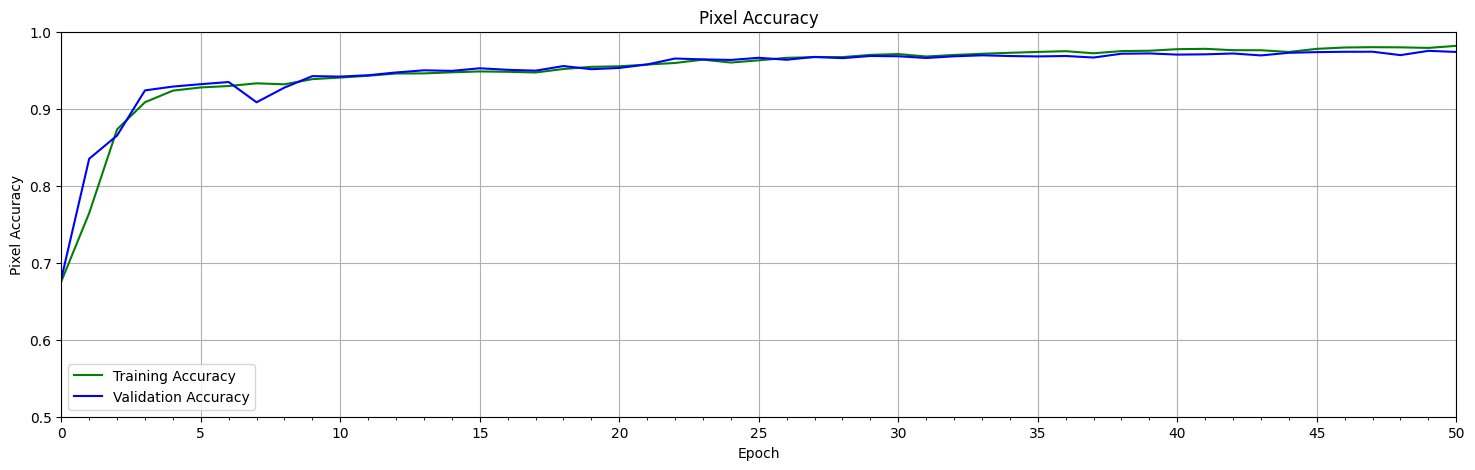

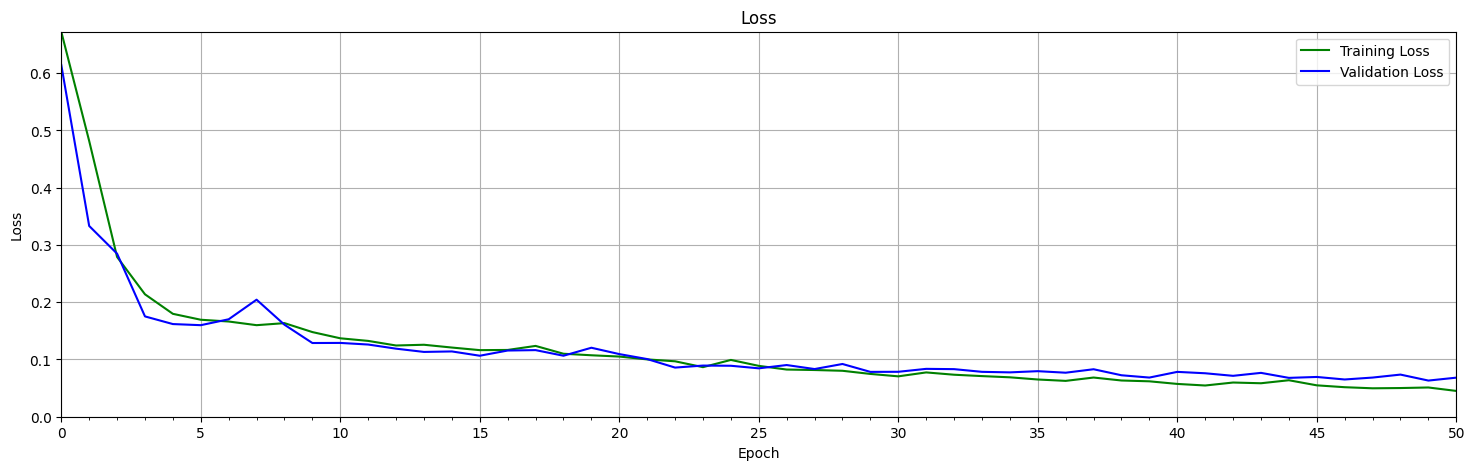

In [22]:
# Retrieve the training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results([ train_acc, valid_acc ],
            ylabel="Pixel Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

max_loss = max(max(train_loss), max(valid_loss))

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## 10 Perform Inference

For inference, we will use the same validation data as we did during training. We will plot the ground truth images, the ground truth masks, and the predicted segmentation maps overlayed on the ground truth images.

### 10.1 Load the Trained Model

In [23]:
trained_model = tf.keras.models.load_model(version_dir)

In [24]:
evaluate = trained_model.evaluate(valid_ds)

print(f"Model evaluation accuracy: {evaluate[1]*100.:.3f}")

5/5 [==============================] - 1s 184ms/step - loss: 0.0631 - accuracy: 0.9752
Model evaluation accuracy: 97.516


### 10.2 Inference

In [25]:
def inference(model, dataset):

    num_batches_to_process = InferenceConfig.NUM_BATCHES

    for idx, data in enumerate(dataset):

        batch_img, batch_mask = data[0], data[1]
        pred_all = (model.predict(batch_img)).astype('float32')
        pred_all = pred_all.argmax(-1)
        batch_img = (batch_img).astype('uint8')
        if idx == num_batches_to_process:
            break

        for i in range(0, len(batch_img)):

            fig = plt.figure(figsize=(20,8))

            # Display the original image.
            ax1 = fig.add_subplot(1,4,1)
            ax1.imshow(batch_img[i])
            ax1.title.set_text('Actual frame')
            plt.axis('off')

            # Display the ground truth mask.
            true_mask = batch_mask[i]
            ax2 = fig.add_subplot(1,4,2)
            ax2.set_title('Ground truth labels')
            ax2.imshow(true_mask)
            plt.axis('off')

            # Display the predicted segmentation mask.
            pred_mask = pred_all[i]
            ax3 = fig.add_subplot(1,4,3)
            ax3.set_title('Predicted labels')
            ax3.imshow(pred_mask)
            plt.axis('off')

            # Display the predicted segmentation mask overlayed on the original image.
            pred_mask_rgb = num_to_rgb(pred_all[i], color_map=id2color_display)
            overlayed_image = image_overlay((batch_img[i]), np.array(pred_mask_rgb.astype('uint8')))
            ax4 = fig.add_subplot(1,4,4)
            ax4.set_title('Overlayed image')
            ax4.imshow(overlayed_image)
            plt.axis('off')

            plt.show()

1/1 [==============================] - 0s 191ms/step


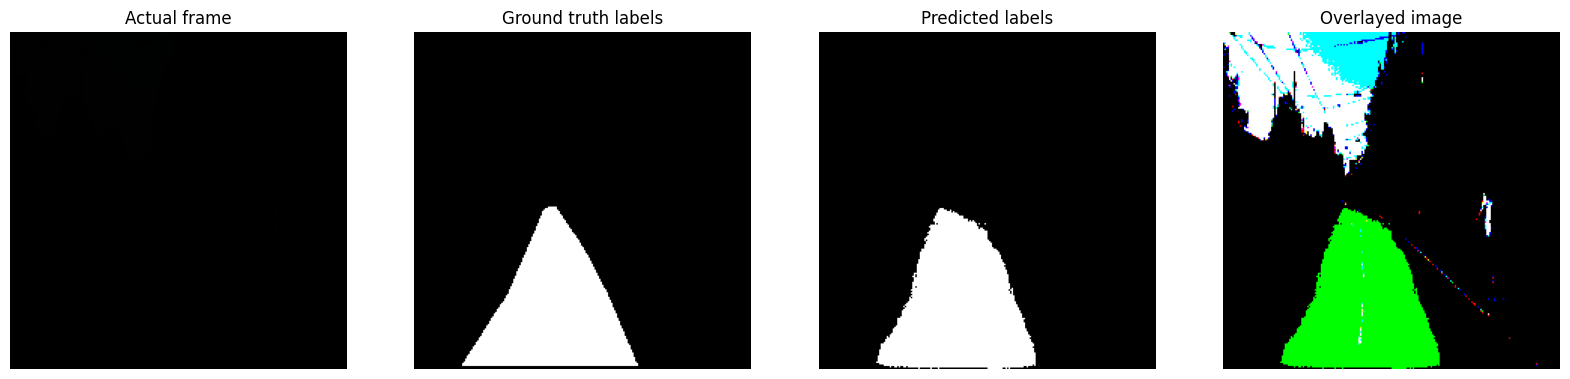

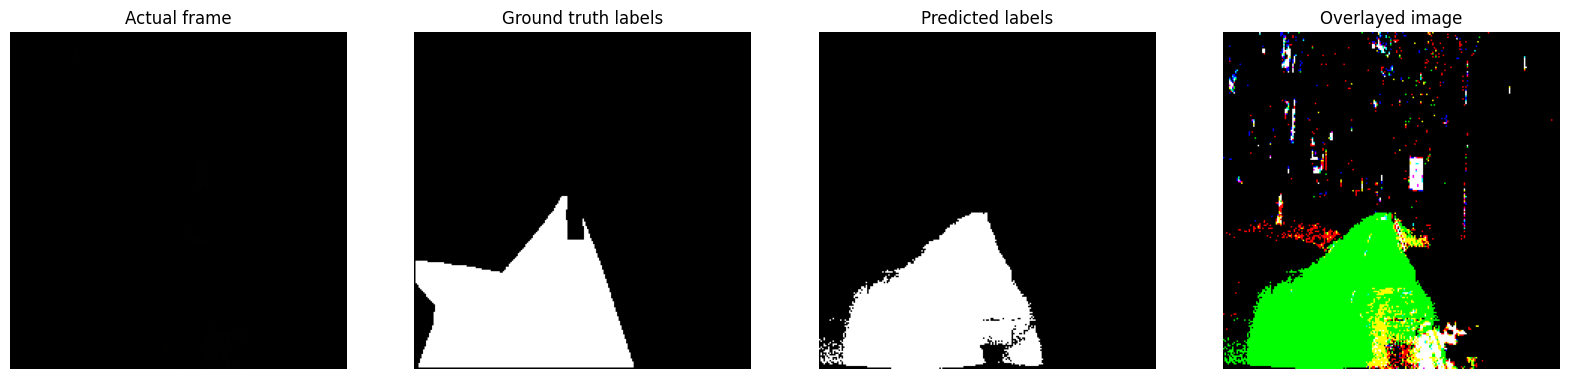

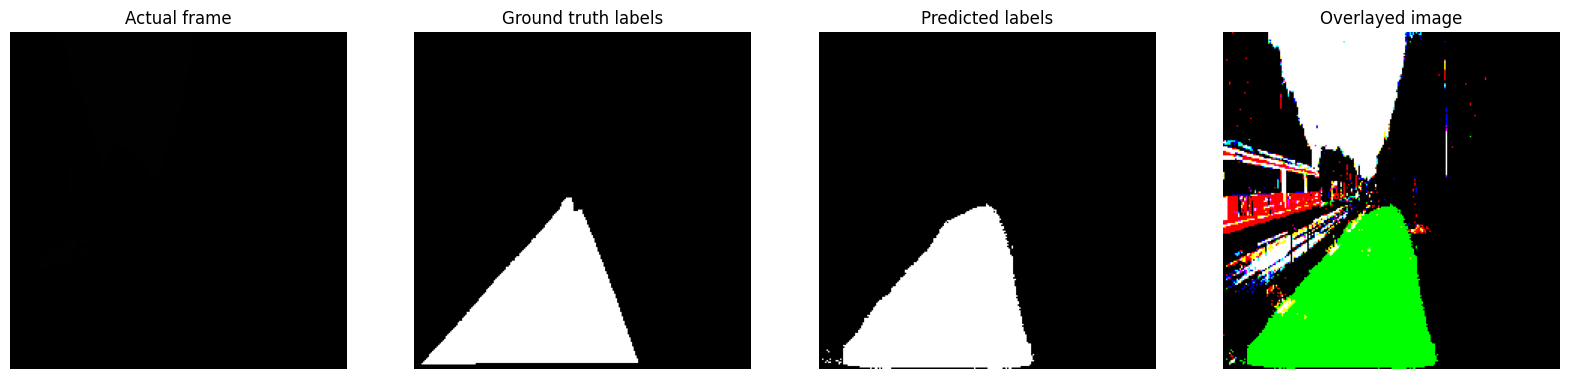

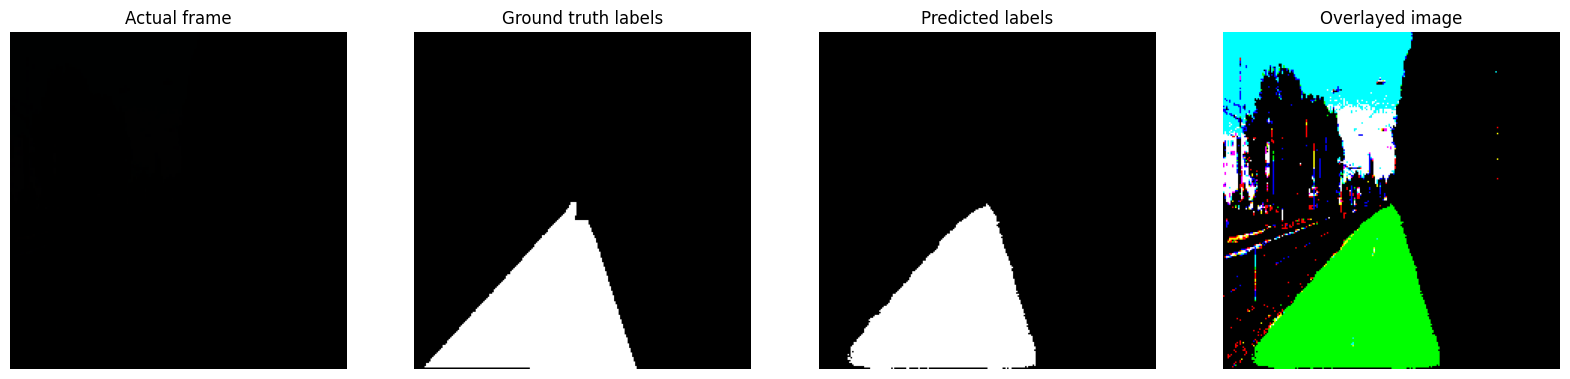

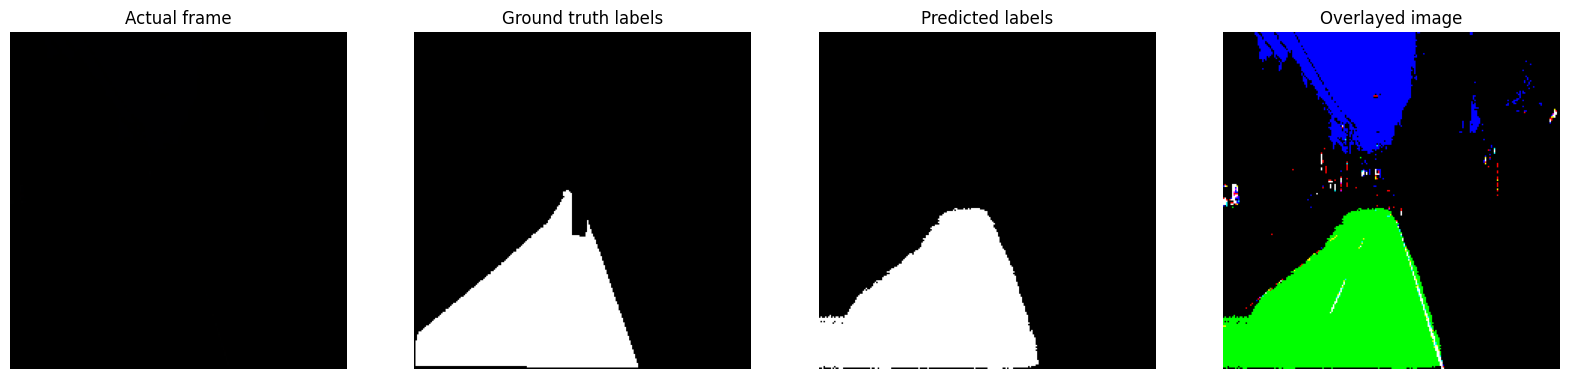

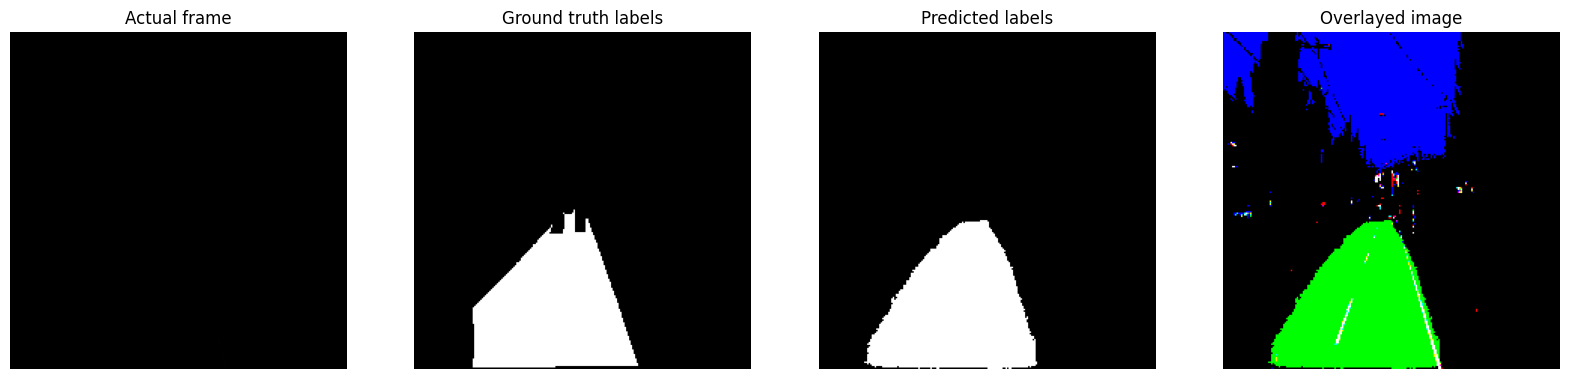

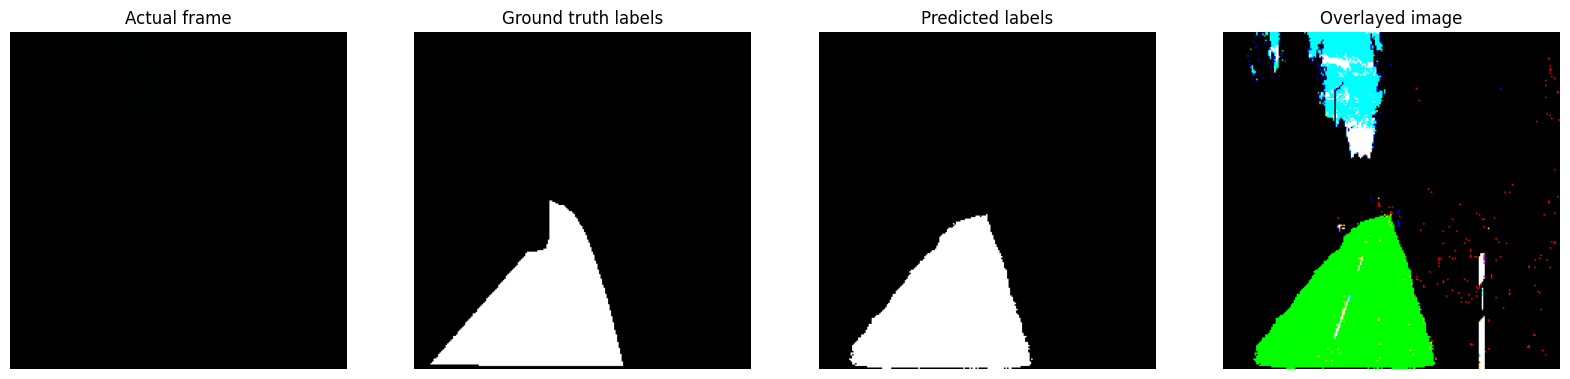

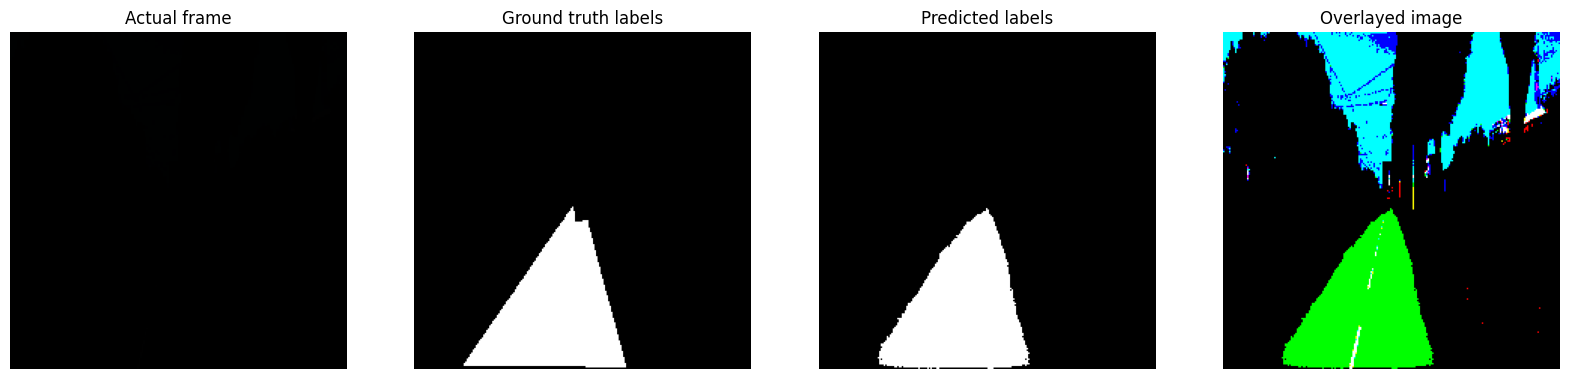

1/1 [==============================] - 0s 25ms/step


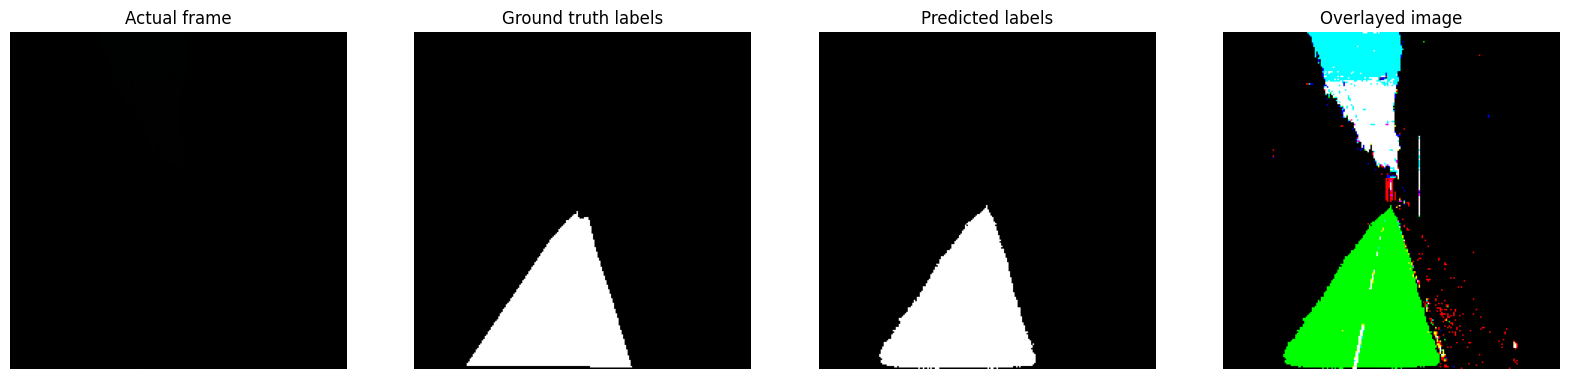

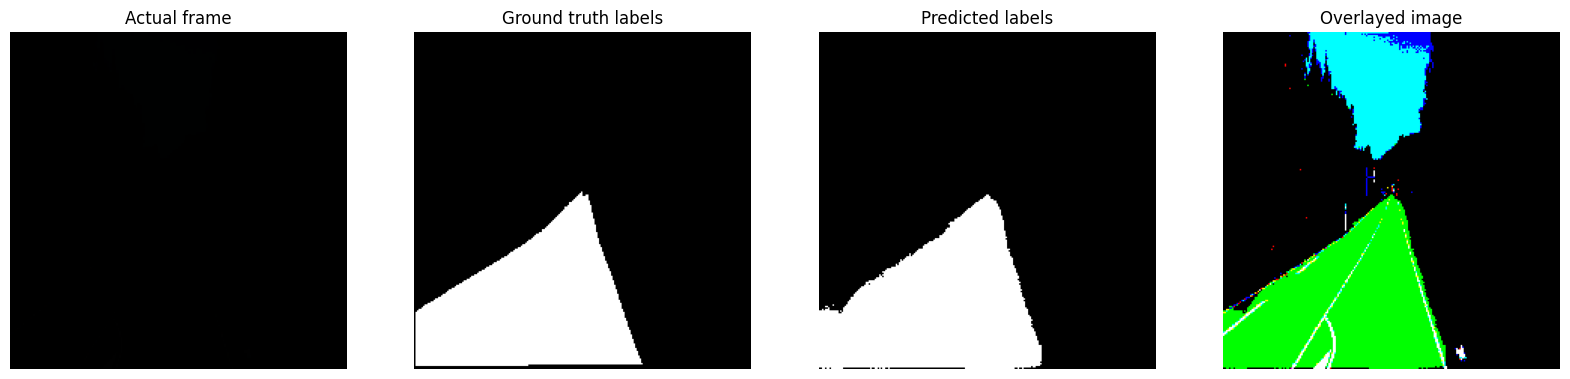

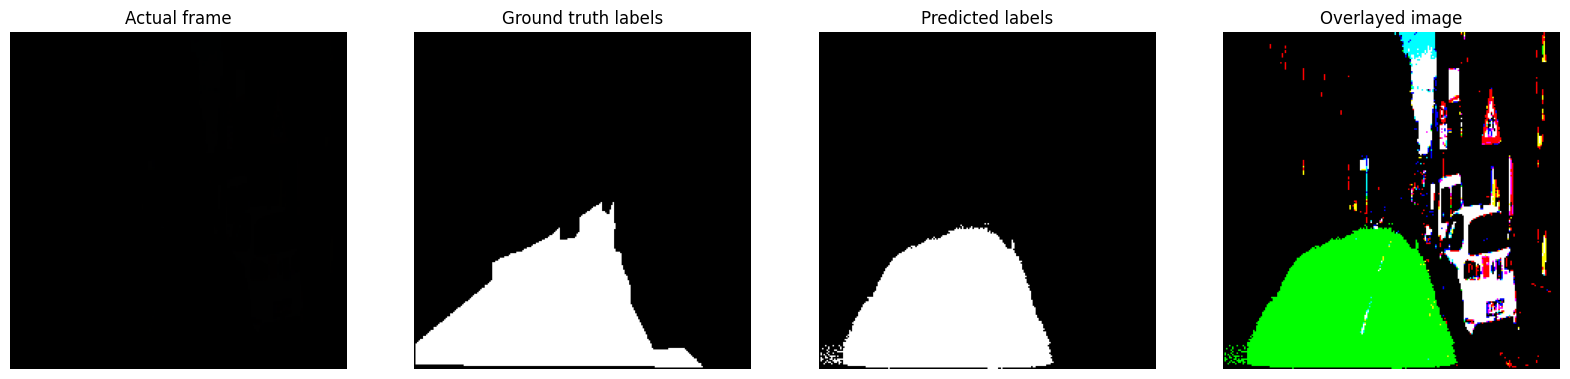

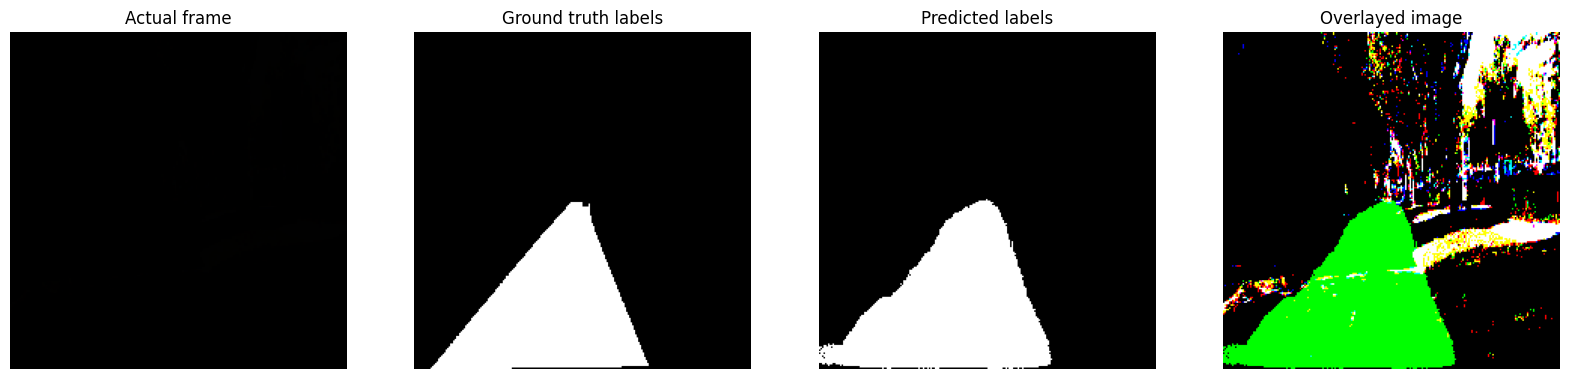

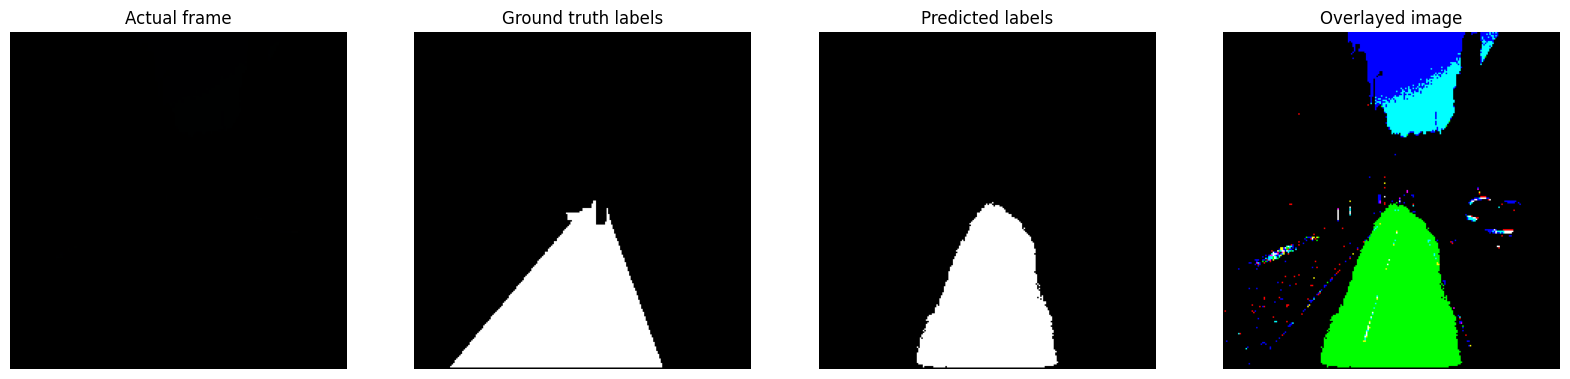

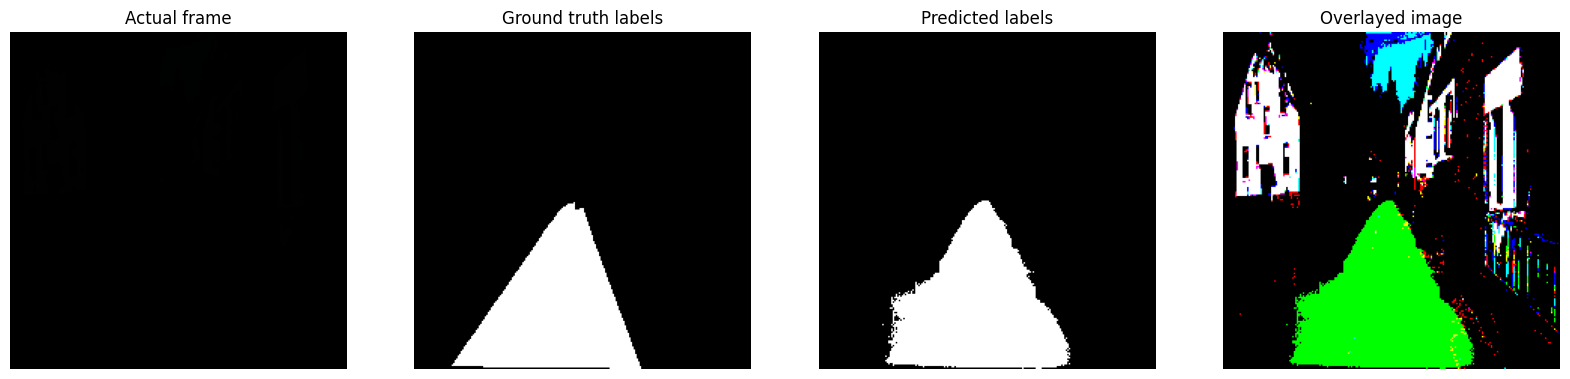

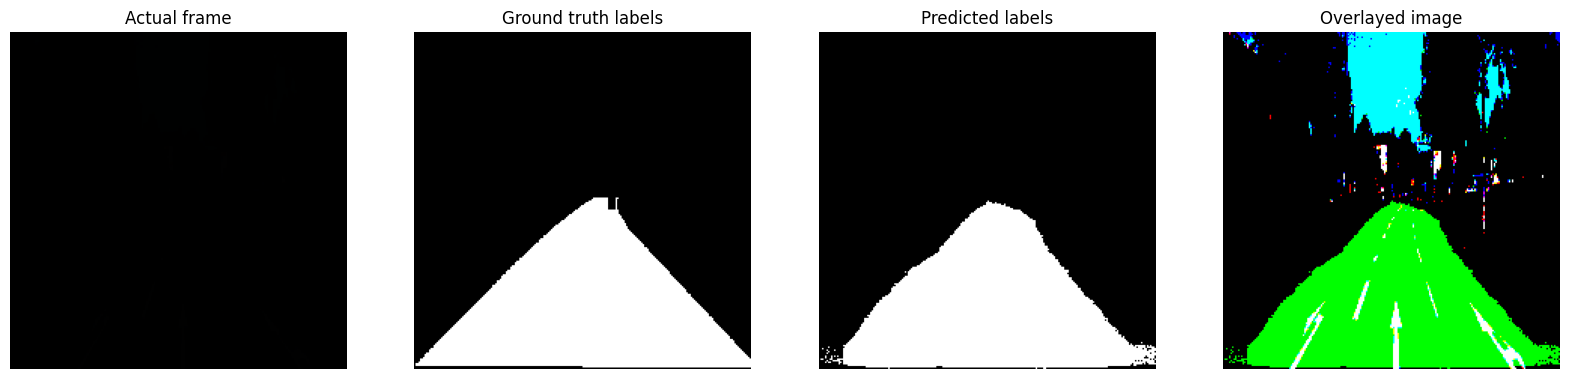

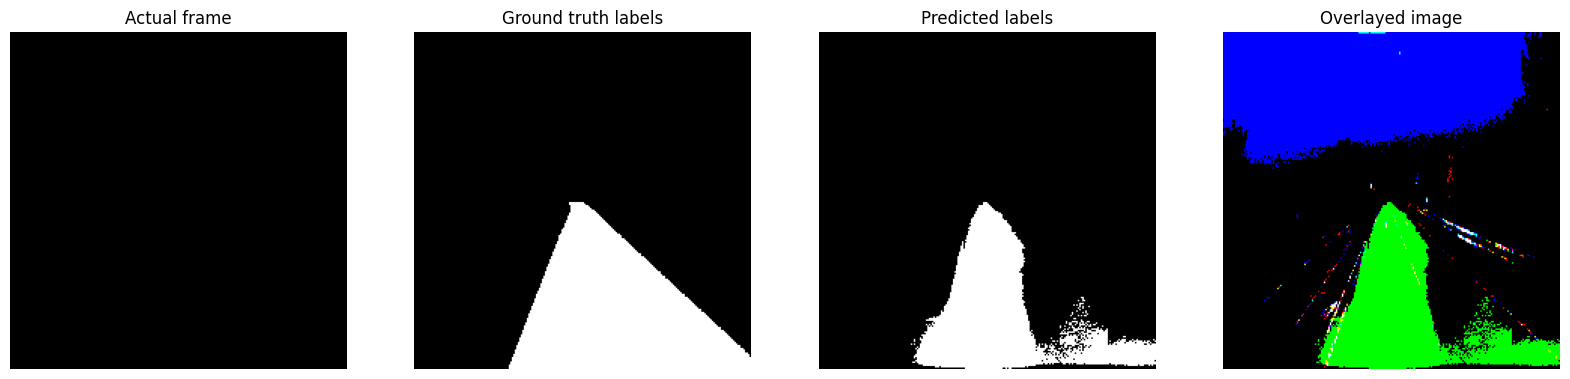

1/1 [==============================] - 0s 37ms/step


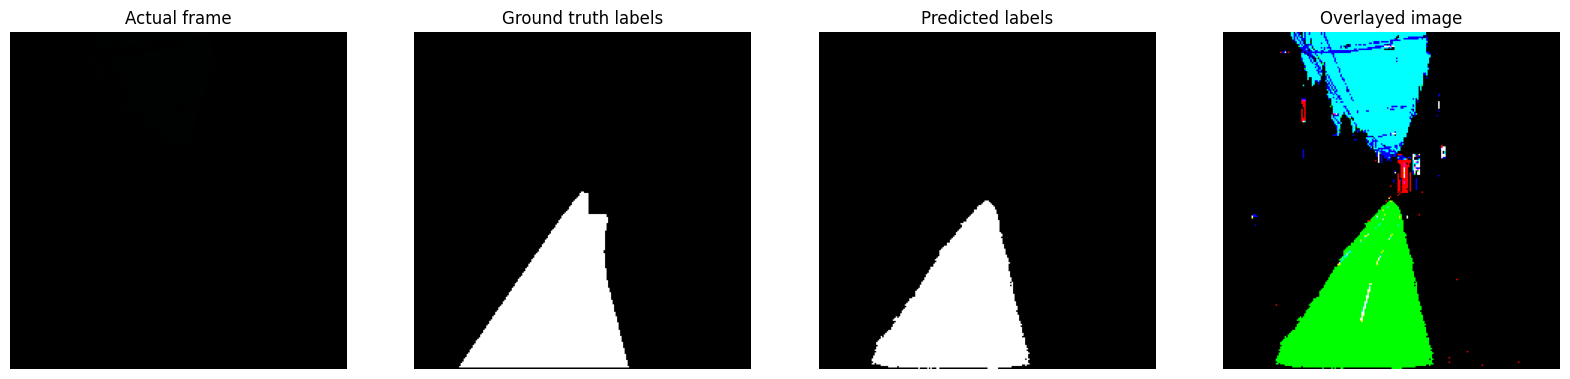

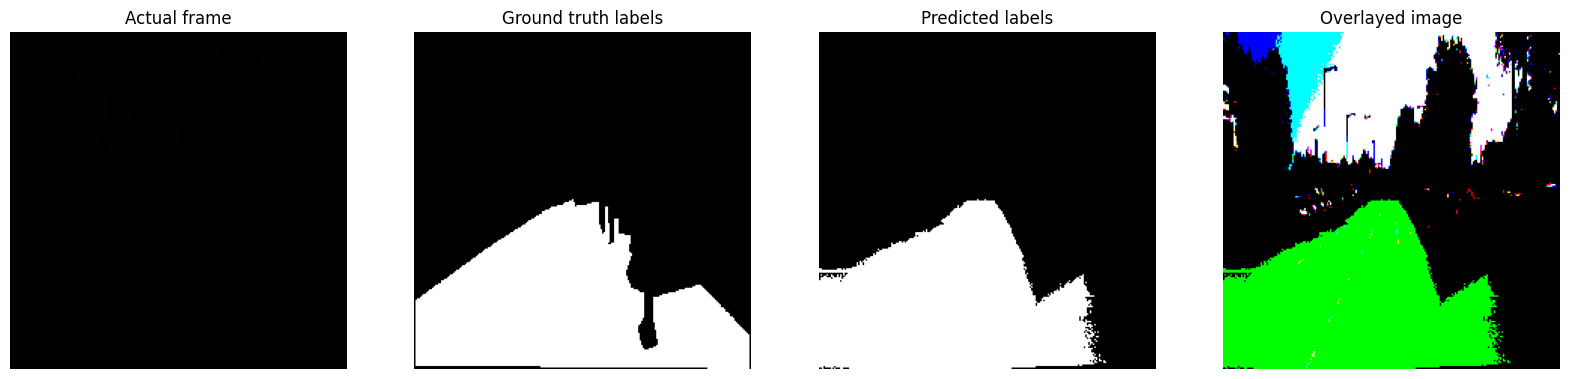

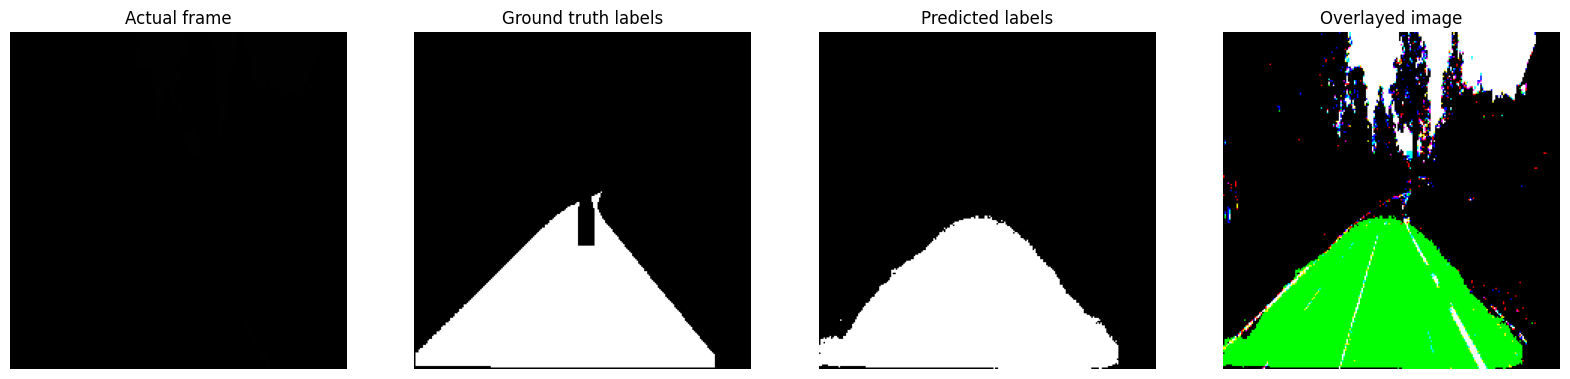

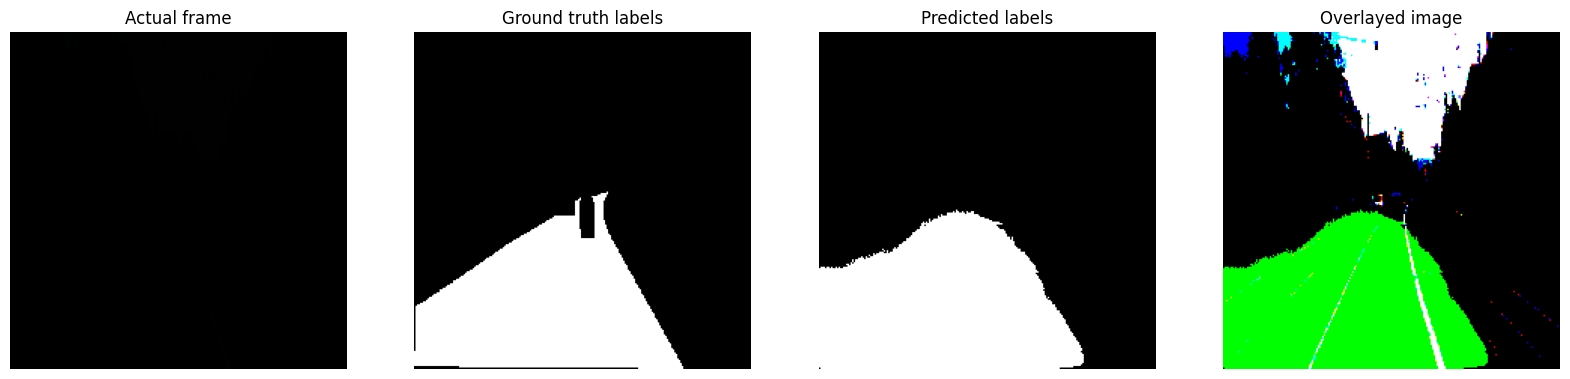

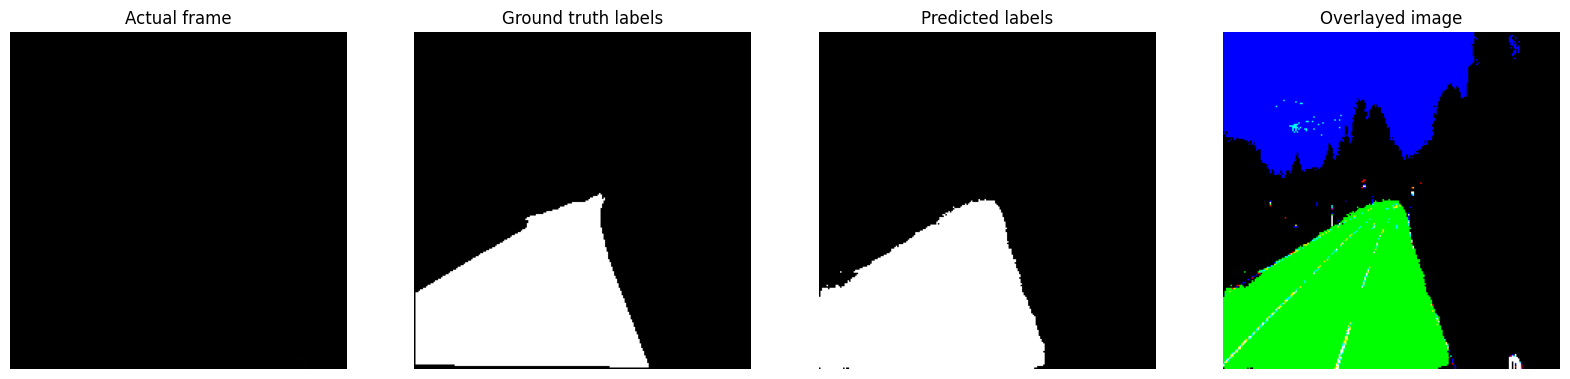

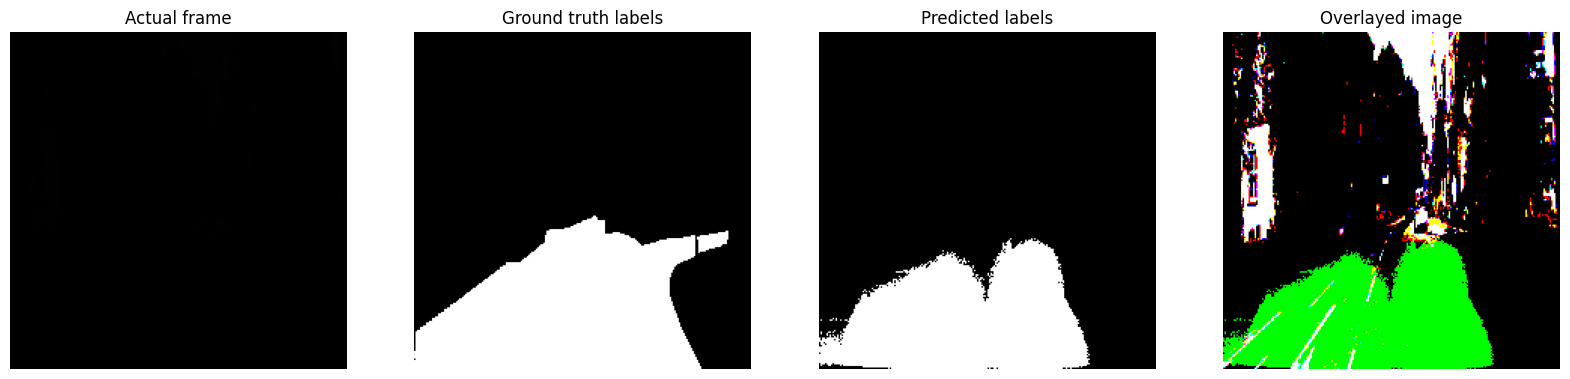

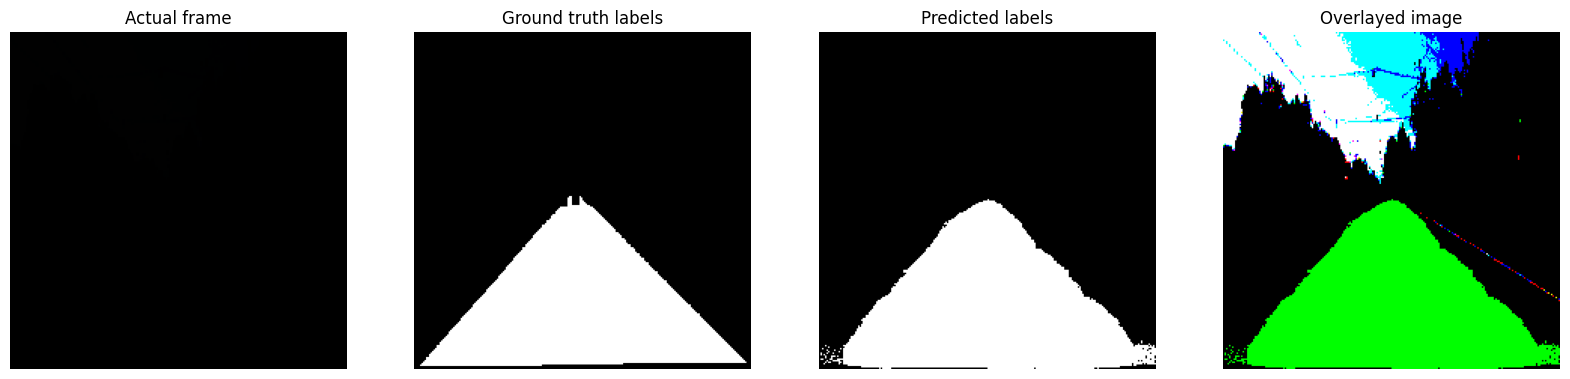

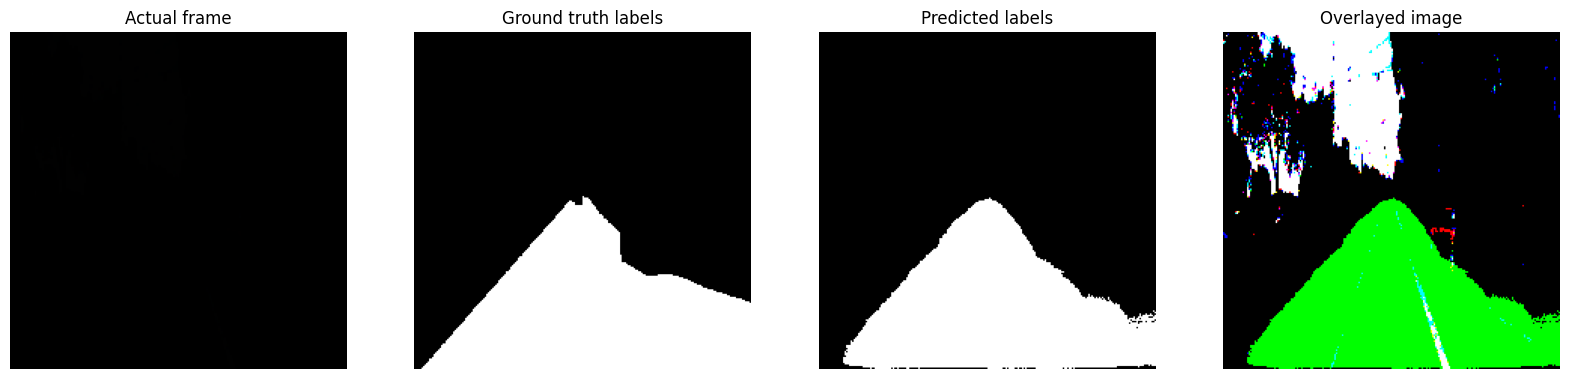

1/1 [==============================] - 0s 27ms/step


In [26]:
inference(trained_model, valid_ds)

## 11 Conclusion

As you can see, the segmentation maps are relatively smooth and fairly accurate, but there are areas that could be improved. There are a couple reasons why this may be the case.

* The FCN-32s model upsamples the feature map using just one transposed convolutional layer with a stride of 32. The use of skip connections in FCN-16s and FCN-8s would obtain better performance.
* We trained VGG-16 from scratch and did not use pre-trained weights. This means that model had to learn everything from scratch. Using pre-trained weights may improve the results and require less training time.

The key takeaways from this notebook are:

* Semantic segmentation requires pixel-level classification, which means we not only need to know **"what"** the image contains but **"where"** in the image things are located.
* The FCN architecture uses feature extraction to learn "what" the image contains (encoding) and then uses **1x1 convolution** to limit the depth of the segmentation map to the number of classes and **transposed convolution** to upsample the coarse feature maps to produce dense (pixel-level) segmentation maps that are the same size as the input image.
* FCN architectures can handle a wide range of image sizes since there is no longer a size constraint imposed by the fully connected layers.
* It's also important to remember that the filters used to perform upsampling are **learned** during training.

In the next notebook, we will learn how to add custom accuracy metrics and custome loss functions to the training pipeline.